In [1]:
import os
# Set working directory, according to working directory in scripts:
os.chdir('/gxfs_work1/geomar/smomw511')
# os.chdir('/Users/mlandt-hayen') # local
# os.chdir('/work') # local in Docker Container

In [49]:
import os
import sys
sys.path.append(
    "GitHub/MarcoLandtHayen/reconstruct_missing_data/reconstruct_missing_data"
)

from pathlib import Path
from json import dump, load

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

from data_loading import (
    find_data_files, 
    load_data_set, 
    get_anomalies, 
    clone_data, 
    create_missing_mask, 
    split_and_scale_data,
    area_mean_weighted,
    spatial_mask,
)
from models import build_unet_4conv
from indices import (
    southern_annular_mode_zonal_mean,
    north_atlantic_oscillation_station,
    north_pacific,
    el_nino_southern_oscillation_34,
    atlantic_multidecadal_oscillation,
)

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, concatenate, Conv1D, Conv2D, MaxPool2D, UpSampling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.utils import plot_model

# Suppress Tensorflow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Set path to final model:

# sst CESM:
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_CESM_fixed_discrete_factor_1_final'
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_CESM_variable_discrete_factor_1_final'
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_CESM_variable_discrete_factor_2_final'
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_CESM_variable_discrete_factor_3_final'
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_CESM_optimal_discrete_factor_1_final'

# sst FOCI:
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_FOCI_fixed_discrete_factor_1_final'
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_FOCI_variable_discrete_factor_1_final'
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_FOCI_variable_discrete_factor_2_final'
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_FOCI_variable_discrete_factor_3_final'
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_FOCI_optimal_discrete_factor_1_final'

# sst realworld:
path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_5conv_sst_realworld_fixed_discrete_factor_1_final'
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_5conv_sst_realworld_variable_discrete_factor_1_final'
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_5conv_sst_realworld_variable_discrete_factor_2_final'
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_5conv_sst_realworld_variable_discrete_factor_3_final'
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_5conv_sst_realworld_optimal_from_CESM_discrete_factor_1_final'
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_5conv_sst_realworld_optimal_from_FOCI_discrete_factor_1_final'




# Reload parameters for this experiment:
with open(Path(path_to_final_model) / 'parameters.json', 'r') as f:
    parameters=load(f)

feature = parameters['feature']
feature_short = parameters['feature_short']
source = parameters['source']
mask_type = parameters['mask_type']
missing_type = parameters['missing_type']
augmentation_factor = parameters['augmentation_factor']
train_val_split = parameters['train_val_split']
missing_values = parameters['missing_values'] #or set manually: [0.999, 0.99, 0.95, 0.9, 0.75, 0.5] 
scale_to = parameters['scale_to']

# Real world data needs separate pre-processing:
if source == 'realworld':
    
    # Path to full data:
    path_to_data = "GitHub/MarcoLandtHayen/reconstruct_missing_data/data/raw/sst.mnmean.nc"  

    ## Load data:

    # Open data set:
    sst_dataset=xr.open_dataset(path_to_data)
  
    # Start with raw slp fields as lat/lon grids in time, from 1948 to 2022:
    sst_fields = (
        sst_dataset.sst
        .sel(time=slice('1880-01-01', '2022-12-01'))
    )

    # Extract time, latitude and longitude dimensions.
    # Already consider, that latitude and longitude are truncated below:
    time = sst_fields['time']
    latitude = sst_fields['lat'][5:-4]
    longitude = sst_fields['lon'][:-4]
    
    # Get number of train and validation samples: Consider augmentation factor!
    n_train = int(len(sst_fields) * augmentation_factor * train_val_split)
    n_val = ((len(sst_fields) * augmentation_factor) - n_train)
    
    # Compute monthly climatology (here 1980 - 2009) for whole world:
    sst_climatology_fields = (
        sst_dataset.sst
        .sel(time=slice('1980-01-01','2009-12-01'))
        .groupby("time.month")
        .mean("time")
    )

    # Get slp anomaly fields by subtracting monthly climatology from raw slp fields:
    sst_anomaly_fields = sst_fields.groupby("time.month") - sst_climatology_fields

    # Remove last row (latidute) and last 4 columns (longitude), to have even number of steps in latitude (=88)
    # and longitude (=176), that can be evenly divided 4 times by two. This serves as 'quick-and-dirty'
    # solution to avoid problems with UPSAMPLING in U-Net. There must be a more elegant way, take care of it later!
    sst_anomaly_fields = sst_anomaly_fields.values[:,5:-4,:-4]
   
    # Extend data, if desired:
    data = clone_data(data=sst_anomaly_fields, augmentation_factor=augmentation_factor)

else:

    # Path to full data:
    path_to_data = 'climate_index_collection/data/raw/2022-08-22/'

    # Load data:
    data = load_data_set(data_path=path_to_data, data_source_name=source)

    # Extract time, latitude and longitude dimensions:
    time = data['time']
    latitude = data['lat']
    longitude = data['lon']

    # Get number of train and validation samples: Consider augmentation factor!
    n_train = int(len(data[feature]) * augmentation_factor * train_val_split)
    n_val = ((len(data[feature]) * augmentation_factor) - n_train)

    # Compute monthly climatology over complete time span for whole world:
    sst_climatology_fields = data[feature].groupby("time.month").mean("time")
    
    # Get slp anomaly fields by subtracting monthly climatology from raw slp fields:
    sst_anomaly_fields = data[feature].groupby("time.month") - sst_climatology_fields

    # Extend data, if desired:
    data = clone_data(data=sst_anomaly_fields, augmentation_factor=augmentation_factor)

# Extend time dimension, according to augmentation factor:
for t in range(len(time)):

    # Loop over augmentation_facor:
    for j in range(augmentation_factor):

        # Initialize storage for extended time line:
        if (t==0) & (j==0):
            extended_time=time[t].values
        else:
            extended_time = np.hstack([extended_time,time[t].values])

# Convert extended time line to xarray DataArray:
extended_time_xr = xr.DataArray(
    extended_time,
    name='time',
    dims=('time'),
    coords={'time': extended_time}
)

In [50]:
# To reduce memory load, consider each sample only once. Use augmentation factor as step size.
# Hence, adjust number of training and validation samples accordingly:
n_train_red = len(np.arange(0,n_train,augmentation_factor))
n_val_red = len(np.arange(0,n_val,augmentation_factor))

In [51]:
# Initialize storage for loss per sample, dimension: (#missing values, #samples)
train_loss_per_sample_all = np.zeros((len(missing_values),n_train_red))
val_loss_per_sample_all = np.zeros((len(missing_values),n_val_red))

# Initialize storage for mean loss maps, dimension: (#missing values, latitude, longitude)
train_loss_map_all = np.zeros((len(missing_values),data.shape[1],data.shape[2]))
val_loss_map_all = np.zeros((len(missing_values),data.shape[1],data.shape[2]))

# Initialize storage for indices, dimension: (#missing values, #samples)
ENSO_train_pred_all = np.zeros((len(missing_values),n_train_red))
ENSO_val_pred_all = np.zeros((len(missing_values),n_val_red))
ENSO_train_target_all = np.zeros((len(missing_values),n_train_red))
ENSO_val_target_all = np.zeros((len(missing_values),n_val_red))

AMO_train_pred_all = np.zeros((len(missing_values),n_train_red))
AMO_val_pred_all = np.zeros((len(missing_values),n_val_red))
AMO_train_target_all = np.zeros((len(missing_values),n_train_red))
AMO_val_target_all = np.zeros((len(missing_values),n_val_red))

In [52]:
# # Loop over rel. amounts of missing values:
# for i in range(len(missing_values)):
i = 0

In [53]:
# Get status:
print('missing: ',i+1,' of ',len(missing_values))

# Get current rel. amount of missing values:
missing = missing_values[i]

## Reconstruct sparse data (as inputs) and complete data (as targets).

# Reload mask for missing values.
# Rel. amount of missing values = 0.999 requires special treatment:
if missing==0.999:
    missing_mask = np.load(Path(path_to_final_model) / 'missing_' f'{int(missing*1000)}' / 'missing_mask.npy')
else:
    missing_mask = np.load(Path(path_to_final_model) / 'missing_' f'{int(missing*100)}' / 'missing_mask.npy')

# Use sparse data as inputs and complete data as targets. Split sparse and complete data into training and validation sets. 
# Scale or normlalize data according to statistics obtained from only training data.
train_input, val_input, train_target, val_target, train_min, train_max, train_mean, train_std = split_and_scale_data(
    data, 
    missing_mask, 
    train_val_split, 
    scale_to
)

missing:  1  of  7


In [54]:
# Reduce inputs and targets, use each sample only once. Augmentation factor determines step size:
train_input = train_input[np.arange(0,n_train,augmentation_factor)]
val_input = val_input[np.arange(0,n_val,augmentation_factor)]
train_target = train_target[np.arange(0,n_train,augmentation_factor)]
val_target = val_target[np.arange(0,n_val,augmentation_factor)]

In [55]:
# Reload model: Rel. amount of missing values = 0.999 requires special treatment.
if missing==0.999:
    model = tf.keras.models.load_model(Path(path_to_final_model) / 'missing_' f'{int(missing*1000)}' / 'model')
else:
    model = tf.keras.models.load_model(Path(path_to_final_model) / 'missing_' f'{int(missing*100)}' / 'model')

# Get predictions:
train_pred = model.predict(train_input)
val_pred = model.predict(val_input)

# Compute loss per sample:
train_loss_per_sample = np.mean((train_pred[:,:,:,0]-train_target)**2,axis=(1,2))
val_loss_per_sample = np.mean((val_pred[:,:,:,0]-val_target)**2,axis=(1,2))

# Store loss per sample:
train_loss_per_sample_all[i] = train_loss_per_sample
val_loss_per_sample_all[i] = val_loss_per_sample

# Compute mean loss maps:
train_loss_map = np.mean((train_pred[:,:,:,0]-train_target)**2,axis=0)
val_loss_map = np.mean((val_pred[:,:,:,0]-val_target)**2,axis=0)

# Store mean loss maps:
train_loss_map_all[i] = train_loss_map
val_loss_map_all[i] = val_loss_map

## Compute and store indices: SAM, NAO, NP

# Convert predictions and targets to xarray.DataArray:
train_pred_xr = xr.DataArray(
    train_pred[:,:,:,0],
    dims=('time', 'lat', 'lon'),
    coords={'time': extended_time[:n_train][np.arange(0,n_train,augmentation_factor)],
            'lat': latitude, 'lon': longitude}
)
val_pred_xr = xr.DataArray(
    val_pred[:,:,:,0],
    dims=('time', 'lat', 'lon'),
    coords={'time': extended_time[n_train:][np.arange(0,n_val,augmentation_factor)], 
            'lat': latitude, 'lon': longitude}
)
train_target_xr = xr.DataArray(
    train_target[:,:,:],
    dims=('time', 'lat', 'lon'),
    coords={'time': extended_time[:n_train][np.arange(0,n_train,augmentation_factor)],
            'lat': latitude, 'lon': longitude}
)
val_target_xr = xr.DataArray(
    val_target[:,:,:],
    dims=('time', 'lat', 'lon'),
    coords={'time': extended_time[n_train:][np.arange(0,n_val,augmentation_factor)],
            'lat': latitude, 'lon': longitude}
)   


In [60]:
# Revert scaling:
train_pred_xr_rescaled = train_pred_xr * (train_max - train_min) + train_min
val_pred_xr_rescaled = val_pred_xr * (train_max - train_min) + train_min
train_target_xr_rescaled = train_target_xr * (train_max - train_min) + train_min
val_target_xr_rescaled = val_target_xr * (train_max - train_min) + train_min

# Add climatology, to restore raw fields:
train_pred_xr_rescaled_fields = train_pred_xr_rescaled.groupby("time.month") + sst_climatology_fields[:,5:-4,:-4]
val_pred_xr_rescaled_fields = val_pred_xr_rescaled.groupby("time.month") + sst_climatology_fields[:,5:-4,:-4]
train_target_xr_rescaled_fields = train_target_xr_rescaled.groupby("time.month") + sst_climatology_fields[:,5:-4,:-4]
val_target_xr_rescaled_fields = val_target_xr_rescaled.groupby("time.month") + sst_climatology_fields[:,5:-4,:-4]

# Compute indices:
ENSO_train_pred = el_nino_southern_oscillation_34(train_pred_xr_rescaled_fields).values
ENSO_val_pred = el_nino_southern_oscillation_34(val_pred_xr_rescaled_fields).values
ENSO_train_target = el_nino_southern_oscillation_34(train_target_xr_rescaled_fields).values
ENSO_val_target = el_nino_southern_oscillation_34(val_target_xr_rescaled_fields).values

AMO_train_pred = atlantic_multidecadal_oscillation(train_pred_xr_rescaled_fields).values
AMO_val_pred = atlantic_multidecadal_oscillation(val_pred_xr_rescaled_fields).values
AMO_train_target = atlantic_multidecadal_oscillation(train_target_xr_rescaled_fields).values
AMO_val_target = atlantic_multidecadal_oscillation(val_target_xr_rescaled_fields).values

# Store indices:
ENSO_train_pred_all[i] = ENSO_train_pred
ENSO_val_pred_all[i] = ENSO_val_pred
ENSO_train_target_all[i] = ENSO_train_target
ENSO_val_target_all[i] = ENSO_val_target

AMO_train_pred_all[i] = AMO_train_pred
AMO_val_pred_all[i] = AMO_val_pred
AMO_train_target_all[i] = AMO_train_target
AMO_val_target_all[i] = AMO_val_target

In [2]:
# Description:
#
# Following [Xiantao et al., 2020] approach: Test U-Net to reconstruct complete data from sparse inputs.
# Opposed to their net, only have 4 instead of 5 convolutional layers.
# Work with sea level pressure (slp) fields from Earth System Models, either FOCI or CESM.

import os
import sys
sys.path.append(
    "GitHub/MarcoLandtHayen/reconstruct_missing_data/reconstruct_missing_data"
)

from pathlib import Path
from json import dump, load

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

from data_loading import (
    find_data_files, 
    load_data_set, 
    get_anomalies, 
    clone_data, 
    create_missing_mask, 
    split_and_scale_data,
    area_mean_weighted,
    spatial_mask,
)
from models import build_unet_4conv
from indices import (
    southern_annular_mode_zonal_mean,
    north_atlantic_oscillation_station,
    north_pacific,
)

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, concatenate, Conv1D, Conv2D, MaxPool2D, UpSampling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.utils import plot_model

# Suppress Tensorflow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Set path to final model:

# slp CESM:
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_CESM_fixed_discrete_factor_1_final'
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_CESM_variable_discrete_factor_1_final'
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_CESM_variable_discrete_factor_2_final'
path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_CESM_variable_discrete_factor_3_final'
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_CESM_optimal_discrete_factor_1_final'

# slp FOCI:
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_FOCI_fixed_discrete_factor_1_final'
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_FOCI_variable_discrete_factor_1_final'
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_FOCI_variable_discrete_factor_2_final'
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_FOCI_variable_discrete_factor_3_final'
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_FOCI_optimal_discrete_factor_1_final'

# slp realworld:
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_realworld_fixed_discrete_factor_1_final'
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_realworld_variable_discrete_factor_1_final'
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_realworld_variable_discrete_factor_2_final'
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_realworld_variable_discrete_factor_3_final'
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_realworld_optimal_from_CESM_discrete_factor_1_final'
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_realworld_optimal_from_FOCI_discrete_factor_1_final'


In [3]:
# Reload parameters for this experiment:
with open(Path(path_to_final_model) / 'parameters.json', 'r') as f:
    parameters=load(f)

feature = parameters['feature']
feature_short = parameters['feature_short']
source = parameters['source']
mask_type = parameters['mask_type']
missing_type = parameters['missing_type']
augmentation_factor = parameters['augmentation_factor']
train_val_split = parameters['train_val_split']
missing_values = parameters['missing_values'] #or set manually: [0.999, 0.99, 0.95, 0.9, 0.75, 0.5] 
scale_to = parameters['scale_to']

# Real world data needs separate pre-processing:
if source == 'realworld':
    
    # Path to full data:
    path_to_data = "GitHub/MarcoLandtHayen/reconstruct_missing_data/data/raw/pres.sfc.mon.mean.nc"  

    ## Load data:

    # Open data set:
    slp_dataset=xr.open_dataset(path_to_data)

    # Extract time, latitude and longitude dimensions.
    # Already consider, that time dimension and latitude are sliced below: Omit last entry, in either case.
    time = slp_dataset['time'][:-1]
    latitude = slp_dataset['lat'][:-1]
    longitude = slp_dataset['lon']
   
    # Start with raw slp fields as lat/lon grids in time, from 1948 to 2022:
    slp_fields = (
        slp_dataset.pres
        .sel(time=slice('1948-01-01', '2022-12-01'))
    )
    
    # Get number of train and validation samples: Consider augmentation factor!
    n_train = int(len(slp_fields) * augmentation_factor * train_val_split)
    n_val = ((len(slp_fields) * augmentation_factor) - n_train)

    # Compute monthly climatology (here 1980 - 2009) for whole world:
    slp_climatology_fields = (
        slp_dataset.pres
        .sel(time=slice('1980-01-01','2009-12-01'))
        .groupby("time.month")
        .mean("time")
    )

    # Get slp anomaly fields by subtracting monthly climatology from raw slp fields:
    slp_anomaly_fields = slp_fields.groupby("time.month") - slp_climatology_fields

    # Remove last row (latidute), to have equal number of steps in latitude (=72). This serves as 'quick-and-dirty'
    # solution to avoid problems with UPSAMPLING in U-Net. There must be a more elegant way, take care of it later!
    slp_anomaly_fields = slp_anomaly_fields.values[:,:-1,:]

    # Extend data, if desired:
    data = clone_data(data=slp_anomaly_fields, augmentation_factor=augmentation_factor)

else:

    # Path to full data:
    path_to_data = 'climate_index_collection/data/raw/2022-08-22/'

    # Load data:
    data = load_data_set(data_path=path_to_data, data_source_name=source)

    # Extract time, latitude and longitude dimensions:
    time = data['time']
    latitude = data['lat']
    longitude = data['lon']

    # Get number of train and validation samples: Consider augmentation factor!
    n_train = int(len(data[feature]) * augmentation_factor * train_val_split)
    n_val = ((len(data[feature]) * augmentation_factor) - n_train)

    # Compute monthly climatology over complete time span for whole world:
    slp_climatology_fields = data[feature].groupby("time.month").mean("time")
    
    # Get slp anomaly fields by subtracting monthly climatology from raw slp fields:
    slp_anomaly_fields = data[feature].groupby("time.month") - slp_climatology_fields

    # Extend data, if desired:
    data = clone_data(data=slp_anomaly_fields, augmentation_factor=augmentation_factor)
    
# Extend time dimension, according to augmentation factor:
for t in range(len(time)):

    # Loop over augmentation_facor:
    for j in range(augmentation_factor):

        # Initialize storage for extended time line:
        if (t==0) & (j==0):
            extended_time=time[t].values
        else:
            extended_time = np.hstack([extended_time,time[t].values])

# Convert extended time line to xarray DataArray:
extended_time_xr = xr.DataArray(
    extended_time,
    name='time',
    dims=('time'),
    coords={'time': extended_time}
)

In [24]:
# To reduce memory load, consider each sample only once. Use augmentation factor as step size.
# Hence, adjust number of training and validation samples accordingly:
n_train_red = len(np.arange(0,n_train,augmentation_factor))
n_val_red = len(np.arange(0,n_val,augmentation_factor))

In [25]:
# Initialize storage for loss per sample, dimension: (#missing values, #samples)
train_loss_per_sample_all = np.zeros((len(missing_values),n_train_red))
val_loss_per_sample_all = np.zeros((len(missing_values),n_val_red))

# Initialize storage for mean loss maps, dimension: (#missing values, latitude, longitude)
train_loss_map_all = np.zeros((len(missing_values),data.shape[1],data.shape[2]))
val_loss_map_all = np.zeros((len(missing_values),data.shape[1],data.shape[2]))

# Initialize storage for indices, dimension: (#missing values, #samples)
SAM_train_pred_all = np.zeros((len(missing_values),n_train_red))
SAM_val_pred_all = np.zeros((len(missing_values),n_val_red))
SAM_train_target_all = np.zeros((len(missing_values),n_train_red))
SAM_val_target_all = np.zeros((len(missing_values),n_val_red))

NAO_train_pred_all = np.zeros((len(missing_values),n_train_red))
NAO_val_pred_all = np.zeros((len(missing_values),n_val_red))
NAO_train_target_all = np.zeros((len(missing_values),n_train_red))
NAO_val_target_all = np.zeros((len(missing_values),n_val_red))

NP_train_pred_all = np.zeros((len(missing_values),n_train_red))
NP_val_pred_all = np.zeros((len(missing_values),n_val_red))
NP_train_target_all = np.zeros((len(missing_values),n_train_red))
NP_val_target_all = np.zeros((len(missing_values),n_val_red))


In [9]:
# # Loop over rel. amounts of missing values:
# for i in range(len(missing_values)):
i = 0

In [10]:
# Get status:
print('missing: ',i+1,' of ',len(missing_values))

# Get current rel. amount of missing values:
missing = missing_values[i]

## Reconstruct sparse data (as inputs) and complete data (as targets).

# Reload mask for missing values.
# Rel. amount of missing values = 0.999 requires special treatment:
if missing==0.999:
    missing_mask = np.load(Path(path_to_final_model) / 'missing_' f'{int(missing*1000)}' / 'missing_mask.npy')
else:
    missing_mask = np.load(Path(path_to_final_model) / 'missing_' f'{int(missing*100)}' / 'missing_mask.npy')

# Use sparse data as inputs and complete data as targets. Split sparse and complete data into training and validation sets. 
# Scale or normlalize data according to statistics obtained from only training data.
train_input, val_input, train_target, val_target, train_min, train_max, train_mean, train_std = split_and_scale_data(
    data, 
    missing_mask, 
    train_val_split, 
    scale_to
)

missing:  1  of  6


In [26]:
# Reduce inputs and targets, use each sample only once. Augmentation factor determines step size:
train_input = train_input[np.arange(0,n_train,augmentation_factor)]
val_input = val_input[np.arange(0,n_val,augmentation_factor)]
train_target = train_target[np.arange(0,n_train,augmentation_factor)]
val_target = val_target[np.arange(0,n_val,augmentation_factor)]

# Reload model: Rel. amount of missing values = 0.999 requires special treatment.
if missing==0.999:
    model = tf.keras.models.load_model(Path(path_to_final_model) / 'missing_' f'{int(missing*1000)}' / 'model')
else:
    model = tf.keras.models.load_model(Path(path_to_final_model) / 'missing_' f'{int(missing*100)}' / 'model')


2023-03-02 08:06:59.792663: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /.singularity.d/libs
2023-03-02 08:06:59.792690: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-02 08:06:59.792705: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (neshcl200): /proc/driver/nvidia/version does not exist
2023-03-02 08:06:59.799135: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [29]:
# Get predictions:
train_pred = model.predict(train_input)
val_pred = model.predict(val_input)

2023-03-02 08:07:32.149620: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [30]:
# Compute loss per sample:
train_loss_per_sample = np.mean((train_pred[:,:,:,0]-train_target)**2,axis=(1,2))
val_loss_per_sample = np.mean((val_pred[:,:,:,0]-val_target)**2,axis=(1,2))

# Store loss per sample:
train_loss_per_sample_all[i] = train_loss_per_sample
val_loss_per_sample_all[i] = val_loss_per_sample

# Compute mean loss maps:
train_loss_map = np.mean((train_pred[:,:,:,0]-train_target)**2,axis=0)
val_loss_map = np.mean((val_pred[:,:,:,0]-val_target)**2,axis=0)

# Store mean loss maps:
train_loss_map_all[i] = train_loss_map
val_loss_map_all[i] = val_loss_map

In [32]:
## Compute and store indices: SAM, NAO, NP

# Convert predictions and targets to xarray.DataArray:
train_pred_xr = xr.DataArray(
    train_pred[:,:,:,0],
    dims=('time', 'lat', 'lon'),
    coords={'time': extended_time[:n_train][np.arange(0,n_train,augmentation_factor)],
            'lat': latitude, 'lon': longitude}
)
val_pred_xr = xr.DataArray(
    val_pred[:,:,:,0],
    dims=('time', 'lat', 'lon'),
    coords={'time': extended_time[n_train:][np.arange(0,n_val,augmentation_factor)], 
            'lat': latitude, 'lon': longitude}
)
train_target_xr = xr.DataArray(
    train_target[:,:,:],
    dims=('time', 'lat', 'lon'),
    coords={'time': extended_time[:n_train][np.arange(0,n_train,augmentation_factor)],
            'lat': latitude, 'lon': longitude}
)
val_target_xr = xr.DataArray(
    val_target[:,:,:],
    dims=('time', 'lat', 'lon'),
    coords={'time': extended_time[n_train:][np.arange(0,n_val,augmentation_factor)],
            'lat': latitude, 'lon': longitude}
)   

In [33]:
# Revert scaling:
train_pred_xr_rescaled = train_pred_xr * (train_max - train_min) + train_min
val_pred_xr_rescaled = val_pred_xr * (train_max - train_min) + train_min
train_target_xr_rescaled = train_target_xr * (train_max - train_min) + train_min
val_target_xr_rescaled = val_target_xr * (train_max - train_min) + train_min

# Add climatology, to restore raw fields:
train_pred_xr_rescaled_fields = train_pred_xr_rescaled.groupby("time.month") + slp_climatology_fields[:,:-1,:]
val_pred_xr_rescaled_fields = val_pred_xr_rescaled.groupby("time.month") + slp_climatology_fields[:,:-1,:]
train_target_xr_rescaled_fields = train_target_xr_rescaled.groupby("time.month") + slp_climatology_fields[:,:-1,:]
val_target_xr_rescaled_fields = val_target_xr_rescaled.groupby("time.month") + slp_climatology_fields[:,:-1,:]

# Compute indices:
SAM_train_pred = southern_annular_mode_zonal_mean(train_pred_xr_rescaled_fields).values
SAM_val_pred = southern_annular_mode_zonal_mean(val_pred_xr_rescaled_fields).values
SAM_train_target = southern_annular_mode_zonal_mean(train_target_xr_rescaled_fields).values
SAM_val_target = southern_annular_mode_zonal_mean(val_target_xr_rescaled_fields).values

NAO_train_pred = north_atlantic_oscillation_station(train_pred_xr_rescaled_fields).values
NAO_val_pred = north_atlantic_oscillation_station(val_pred_xr_rescaled_fields).values
NAO_train_target = north_atlantic_oscillation_station(train_target_xr_rescaled_fields).values
NAO_val_target = north_atlantic_oscillation_station(val_target_xr_rescaled_fields).values

NP_train_pred = north_pacific(train_pred_xr_rescaled_fields).values
NP_val_pred = north_pacific(val_pred_xr_rescaled_fields).values
NP_train_target = north_pacific(train_target_xr_rescaled_fields).values
NP_val_target = north_pacific(val_target_xr_rescaled_fields).values

# Store indices:
SAM_train_pred_all[i] = SAM_train_pred
SAM_val_pred_all[i] = SAM_val_pred
SAM_train_target_all[i] = SAM_train_target
SAM_val_target_all[i] = SAM_val_target

NAO_train_pred_all[i] = NAO_train_pred
NAO_val_pred_all[i] = NAO_val_pred
NAO_train_target_all[i] = NAO_train_target
NAO_val_target_all[i] = NAO_val_target

NP_train_pred_all[i] = NP_train_pred
NP_val_pred_all[i] = NP_val_pred
NP_train_target_all[i] = NP_train_target
NP_val_target_all[i] = NP_val_target

In [4]:
# Description:
#
# Following [Xiantao et al., 2020] approach: Test U-Net to reconstruct complete data from sparse inputs.
# Opposed to their net, only have 4 instead of 5 convolutional layers.
# Work with sea level pressure (slp) fields from Earth System Models, either FOCI or CESM.

import os
import sys
sys.path.append('../reconstruct_missing_data')

from pathlib import Path
from json import dump, load

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

from data_loading import (
    find_data_files, 
    load_data_set, 
    get_anomalies, 
    clone_data, 
    create_missing_mask, 
    split_and_scale_data,
    area_mean_weighted,
    spatial_mask,
)
from models import build_unet_4conv
from indices import (
    southern_annular_mode_zonal_mean,
    north_atlantic_oscillation_station,
    north_pacific,
)

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, concatenate, Conv1D, Conv2D, MaxPool2D, UpSampling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.utils import plot_model

# Suppress Tensorflow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Set path to final model:

# slp CESM:
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_CESM_fixed_discrete_factor_1_final'
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_CESM_variable_discrete_factor_1_final'
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_CESM_variable_discrete_factor_2_final'
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_CESM_variable_discrete_factor_3_final'
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_CESM_optimal_discrete_factor_1_final'

# slp FOCI:
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_FOCI_fixed_discrete_factor_1_final'
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_FOCI_variable_discrete_factor_1_final'
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_FOCI_variable_discrete_factor_2_final'
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_FOCI_variable_discrete_factor_3_final'
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_FOCI_optimal_discrete_factor_1_final'

# slp realworld:
path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_realworld_fixed_discrete_factor_1_final'
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_realworld_variable_discrete_factor_1_final'
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_realworld_variable_discrete_factor_2_final'
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_realworld_variable_discrete_factor_3_final'
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_realworld_optimal_from_CESM_discrete_factor_1_final'
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_realworld_optimal_from_FOCI_discrete_factor_1_final'



# Reload parameters for this experiment:
with open(Path(path_to_final_model) / 'parameters.json', 'r') as f:
    parameters=load(f)

feature = parameters['feature']
feature_short = parameters['feature_short']
source = parameters['source']
mask_type = parameters['mask_type']
missing_type = parameters['missing_type']
augmentation_factor = parameters['augmentation_factor']
train_val_split = parameters['train_val_split']
missing_values = parameters['missing_values'] #or set manually: [0.999, 0.99, 0.95, 0.9, 0.75, 0.5] 
scale_to = parameters['scale_to']

# Real world data needs separate pre-processing:
if source == 'realworld':
    
    # Path to full data:
    path_to_data = "GitHub/MarcoLandtHayen/reconstruct_missing_data/data/raw/pres.sfc.mon.mean.nc"  

    ## Load data:

    # Open data set:
    slp_dataset=xr.open_dataset(path_to_data)

    # Extract time, latitude and longitude dimensions.
    # Already consider, that time dimension and latitude are sliced below: Omit last entry, in either case.
    time = slp_dataset['time'][:-1]
    latitude = slp_dataset['lat'][:-1]
    longitude = slp_dataset['lon']
   
    # Start with raw slp fields as lat/lon grids in time, from 1948 to 2022:
    slp_fields = (
        slp_dataset.pres
        .sel(time=slice('1948-01-01', '2022-12-01'))
    )
    
    # Get number of train and validation samples: Consider augmentation factor!
    n_train = int(len(slp_fields) * augmentation_factor * train_val_split)
    n_val = ((len(slp_fields) * augmentation_factor) - n_train)

    # Compute monthly climatology (here 1980 - 2009) for whole world:
    slp_climatology_fields = (
        slp_dataset.pres
        .sel(time=slice('1980-01-01','2009-12-01'))
        .groupby("time.month")
        .mean("time")
    )

    # Get slp anomaly fields by subtracting monthly climatology from raw slp fields:
    slp_anomaly_fields = slp_fields.groupby("time.month") - slp_climatology_fields

    # Remove last row (latidute), to have equal number of steps in latitude (=72). This serves as 'quick-and-dirty'
    # solution to avoid problems with UPSAMPLING in U-Net. There must be a more elegant way, take care of it later!
    slp_anomaly_fields = slp_anomaly_fields.values[:,:-1,:]

    # Extend data, if desired:
    data = clone_data(data=slp_anomaly_fields, augmentation_factor=augmentation_factor)

else:

    # Path to full data:
    path_to_data = 'climate_index_collection/data/raw/2022-08-22/'

    # Load data:
    data = load_data_set(data_path=path_to_data, data_source_name=source)

    # Extract time, latitude and longitude dimensions:
    time = data['time']
    latitude = data['lat']
    longitude = data['lon']

    # Get number of train and validation samples: Consider augmentation factor!
    n_train = int(len(data[feature]) * augmentation_factor * train_val_split)
    n_val = ((len(data[feature]) * augmentation_factor) - n_train)

    # Compute monthly climatology over complete time span for whole world:
    slp_climatology_fields = data[feature].groupby("time.month").mean("time")
    
    # Get slp anomaly fields by subtracting monthly climatology from raw slp fields:
    slp_anomaly_fields = data[feature].groupby("time.month") - slp_climatology_fields

    # Extend data, if desired:
    data = clone_data(data=slp_anomaly_fields, augmentation_factor=augmentation_factor)

    
# Extend time dimension, according to augmentation factor:
for t in range(len(time)):

    # Loop over augmentation_facor:
    for j in range(augmentation_factor):

        # Initialize storage for extended time line:
        if (t==0) & (j==0):
            extended_time=time[t].values
        else:
            extended_time = np.hstack([extended_time,time[t].values])

# Convert extended time line to xarray DataArray:
extended_time_xr = xr.DataArray(
    extended_time,
    name='time',
    dims=('time'),
    coords={'time': extended_time}
)

In [5]:
slp_dataset

<xarray.Dataset>
Dimensions:  (lat: 73, lon: 144, time: 901)
Coordinates:
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2023-01-01
Data variables:
    pres     (time, lat, lon) float32 ...
Attributes:
    description:    Data is from NMC initialized reanalysis\n(4x/day).  These...
    platform:       Model
    Conventions:    COARDS
    NCO:            20121012
    history:        Thu May  4 18:12:05 2000: ncrcat -d time,0,622 /Datasets/...
    title:          monthly mean pres.sfc from the NCEP Reanalysis
    dataset_title:  NCEP-NCAR Reanalysis 1
    References:     http://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis...

In [64]:
data_raw = load_data_set(data_path=path_to_data, data_source_name=source)

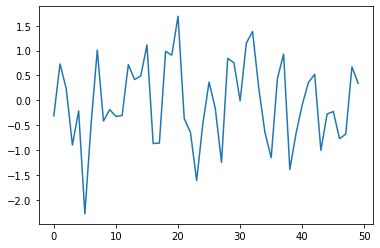

In [71]:
# Calculate raw SAM, on raw slp fields:
#SAM_raw = southern_annular_mode_zonal_mean(slp_fields).values # real world
SAM_raw = southern_annular_mode_zonal_mean(data_raw[feature]).values # CESM / FOCI

n_train_adj = int(n_train / augmentation_factor)

# Plot raw SAM from raw fields, only validation time span:
plt.plot(SAM_raw[n_train_adj:n_train_adj+50])

In [72]:
i = 2

missing = missing_values[i]

## Reconstruct sparse data (as inputs) and complete data (as targets).

# Reload mask for missing values.
# Rel. amount of missing values = 0.999 requires special treatment:
if missing==0.999:
    missing_mask = np.load(Path(path_to_final_model) / 'missing_' f'{int(missing*1000)}' / 'missing_mask.npy')
else:
    missing_mask = np.load(Path(path_to_final_model) / 'missing_' f'{int(missing*100)}' / 'missing_mask.npy')

# Use sparse data as inputs and complete data as targets. Split sparse and complete data into training and validation sets. 
# Scale or normlalize data according to statistics obtained from only training data.
train_input, val_input, train_target, val_target, train_min, train_max, train_mean, train_std = split_and_scale_data(
    data, 
    missing_mask, 
    train_val_split, 
    scale_to
)

# Reload model: Rel. amount of missing values = 0.999 requires special treatment.
if missing==0.999:
    model = tf.keras.models.load_model(Path(path_to_final_model) / 'missing_' f'{int(missing*1000)}' / 'model')
else:
    model = tf.keras.models.load_model(Path(path_to_final_model) / 'missing_' f'{int(missing*100)}' / 'model')

# Get predictions:
#train_pred = model.predict(train_input)
val_pred = model.predict(val_input)

# Compute loss per sample:
#train_loss_per_sample = np.mean((train_pred[:,:,:,0]-train_target)**2,axis=(1,2))
val_loss_per_sample = np.mean((val_pred[:,:,:,0]-val_target)**2,axis=(1,2))

# Store loss per sample:
#train_loss_per_sample_all[i] = train_loss_per_sample
#val_loss_per_sample_all[i] = val_loss_per_sample

# Compute mean loss maps:
#train_loss_map = np.mean((train_pred[:,:,:,0]-train_target)**2,axis=0)
val_loss_map = np.mean((val_pred[:,:,:,0]-val_target)**2,axis=0)

# Store mean loss maps:
#train_loss_map_all[i] = train_loss_map
#val_loss_map_all[i] = val_loss_map

## Compute and store indices: SAM, NAO, NP

# Convert predictions and targets to xarray.DataArray:
# train_pred_xr = xr.DataArray(
#     train_pred[:,:,:,0],
#     dims=('time', 'lat', 'lon'),
#     coords={'time': extended_time[:n_train], 'lat': latitude, 'lon': longitude}
# )
val_pred_xr = xr.DataArray(
    val_pred[:,:,:,0],
    dims=('time', 'lat', 'lon'),
    coords={'time': extended_time[n_train:], 'lat': latitude, 'lon': longitude}
)
# train_target_xr = xr.DataArray(
#     train_target[:,:,:],
#     dims=('time', 'lat', 'lon'),
#     coords={'time': extended_time[:n_train], 'lat': latitude, 'lon': longitude}
# )
val_target_xr = xr.DataArray(
    val_target[:,:,:],
    dims=('time', 'lat', 'lon'),
    coords={'time': extended_time[n_train:], 'lat': latitude, 'lon': longitude}
)   



In [73]:
# Compute indices on scaled predictions and targets (= anomaly fields):
SAM_val_pred = southern_annular_mode_zonal_mean(val_pred_xr).values
SAM_val_target = southern_annular_mode_zonal_mean(val_target_xr).values

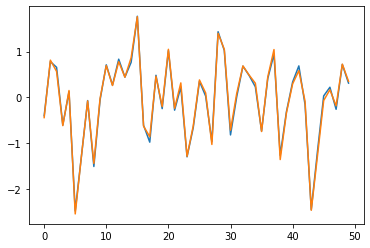

In [74]:
# Plot SAM, from anomaly fields, scaled
plt.plot(SAM_val_pred[np.arange(0,100,2)])
plt.plot(SAM_val_target[np.arange(0,100,2)])

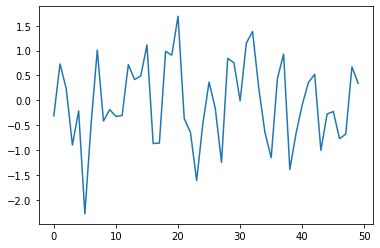

In [75]:
# Plot raw SAM from raw fields, only validation time span:
plt.plot(SAM_raw[n_train_adj:n_train_adj+50])

In [76]:
# Revert scaling:
#train_pred_xr_rescaled = train_pred_xr * (train_max - train_min) + train_min
val_pred_xr_rescaled = val_pred_xr * (train_max - train_min) + train_min
#train_target_xr_rescaled = train_target_xr * (train_max - train_min) + train_min
val_target_xr_rescaled = val_target_xr * (train_max - train_min) + train_min

# Add climatology, to restore raw fields:
#train_pred_xr_rescaled_fields = train_pred_xr_rescaled.groupby("time.month") + slp_climatology_fields[:,:-1,:]
val_pred_xr_rescaled_fields = val_pred_xr_rescaled.groupby("time.month") + slp_climatology_fields[:,:-1,:]
#train_target_xr_rescaled_fields = train_target_xr_rescaled.groupby("time.month") + slp_climatology_fields[:,:-1,:]
val_target_xr_rescaled_fields = val_target_xr_rescaled.groupby("time.month") + slp_climatology_fields[:,:-1,:]

# Compute indices:
#SAM_train_pred = southern_annular_mode_zonal_mean(train_pred_xr_rescaled_fields).values
SAM_val_pred_revert = southern_annular_mode_zonal_mean(val_pred_xr_rescaled_fields).values
#SAM_train_target = southern_annular_mode_zonal_mean(train_target_xr_rescaled_fields).values
SAM_val_target_revert = southern_annular_mode_zonal_mean(val_target_xr_rescaled_fields).values

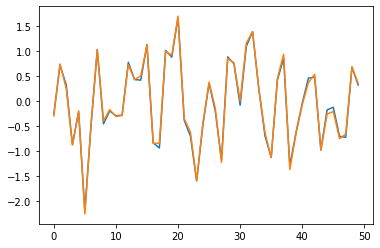

In [77]:
# Plot SAM, from reverted fields
plt.plot(SAM_val_pred_revert[np.arange(0,100,2)])
plt.plot(SAM_val_target_revert[np.arange(0,100,2)])

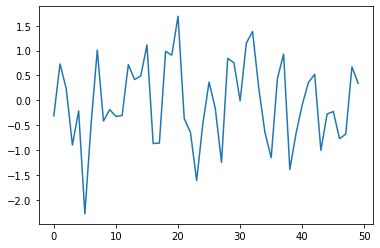

In [78]:
# Plot raw SAM from raw fields, only validation time span:
plt.plot(SAM_raw[n_train_adj:n_train_adj+50])

In [2]:
import sys
sys.path.append('../reconstruct_missing_data')

from data_loading import find_data_files, load_data_set, get_anomalies, create_missing_mask, split_and_scale_data, clone_data

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import xarray as xr
from pathlib import Path
from json import dump, load
import os

In [6]:
# Check current working directory:
print(os.getcwd())

/gxfs_work1/geomar/smomw511


In [4]:
# Set working directory, according to working directory in scripts:
os.chdir('/gxfs_work1/geomar/smomw511')
# os.chdir('/Users/mlandt-hayen') # local
# os.chdir('/work') # local in Docker Container

In [4]:
# Look for slp real world data:
find_data_files(data_path='../data/', data_source_name='raw')

[PosixPath('../data/raw/pres.sfc.mon.mean.nc')]

In [6]:
# Open data set:
# slp_dataset=xr.open_dataset("../data/raw/pres.sfc.mon.mean.nc")
slp_dataset=xr.open_dataset("GitHub/MarcoLandtHayen/reconstruct_missing_data/data/raw/pres.sfc.mon.mean.nc")

# Start with raw slp fields as lat/lon grids in time, from 1948 to 2022:
slp_fields = (
    slp_dataset.pres
    .sel(time=slice('1948-01-01', '2022-12-01'))
)

# Compute monthly climatology (here 1980 - 2009) for whole world:
slp_climatology_fields = (
    slp_dataset.pres
    .sel(time=slice('1980-01-01','2009-12-01'))
    .groupby("time.month")
    .mean("time")
)

# Get slp anomaly fields by subtracting monthly climatology from raw slp fields:
slp_anomaly_fields = slp_fields.groupby("time.month") - slp_climatology_fields

# Remove last row (latidute), to have equal number of steps in latitude (=72). This serves as 'quick-and-dirty'
# solution to avoid problems with UPSAMPLING in U-Net. There must be a more elegant way, take care of it later!
slp_anomaly_fields = slp_anomaly_fields.values[:,:-1,:]

In [7]:
slp_anomaly_fields.shape

(900, 72, 144)

In [ ]:
### Compute area averaged total SST from Niño 3.4 region (5°N–5°S, 120–170°W).
# Note: Since the box of interest is close to equator (5°N-5°S) we simply average over the box area and don't take care
# care of area weighting here.
# Note: latitude comes in a grid 88, 86, .., -86, 88, slice(5,-5) is actually using (4°N-4°S) only.
# Note: longitude ranges from 0 to 358°E. Region of interest (120-170°W) translates to (190°E-240°E) here.
sst_mean = (
    sst_dataset.sst.sel(time=slice('1880-01-01', '2021-11-01'))
    .sel(lat=slice(5,-5)).sel(lon=slice(190,240))
    .mean(("lat", "lon"))
)

# Compute monthly climatology (here: 1980-2009) for area averaged total SST from Niño 3.4 region.
# "Monthly" means grouping by month before calculating average over time.
sst_climatology_monthly = (
    sst_dataset.sst
    .sel(time=slice('1980-01-01','2009-12-01'))
    .sel(lat=slice(5,-5))
    .sel(lon=slice(190,240))
    .mean(("lat", "lon"))
    .groupby("time.month")
    .mean("time")    
)

# Compute std dev in time for total climatology (here: 1980-2009), 
# use area averaged total SST from Niño 3.4 region
sst_climatology_total_std = (
    sst_dataset.sst
    .sel(time=slice('1980-01-01','2009-12-01'))
    .sel(lat=slice(5,-5))
    .sel(lon=slice(190,240))
    .mean(("lat", "lon"))
    .std("time")          
)

# Subtract monthly climatology from area averaged total SST time series to obtain anomalies
sst_anomaly_monthly = sst_mean.groupby("time.month") - sst_climatology_monthly

# ENSO index is calculated as 5 months rolling mean of sst anomaly.
# We aim to label time sclices of lat/lon grids according to their phase: "El Nino" / "La Nina".
# This requires sst_anomaly WITHOUT rolling mean!
# But still normalize sst anomaly by dividing by standard deviation of sst climatology, as required for ENSO index:
sst_anomaly_norm = sst_anomaly_monthly / sst_climatology_total_std

In [10]:
# Open data set:
sst_dataset=xr.open_dataset("GitHub/MarcoLandtHayen/reconstruct_missing_data/data/raw/sst.mnmean.nc")

# Start with raw slp fields as lat/lon grids in time, from 1880 to 2022:
sst_fields = (
    sst_dataset.sst
    .sel(time=slice('1880-01-01', '2022-12-01'))
)

# Compute monthly climatology (here 1980 - 2009) for whole world:
sst_climatology_fields = (
    sst_dataset.sst
    .sel(time=slice('1980-01-01','2009-12-01'))
    .groupby("time.month")
    .mean("time")
)

# Get slp anomaly fields by subtracting monthly climatology from raw slp fields:
sst_anomaly_fields = sst_fields.groupby("time.month") - sst_climatology_fields

# Remove last row (latidute) and last 4 columns (longitude), to have even number of steps in latitude (=88)
# and longitude (=176), that can be evenly divided 4 times by two. This serves as 'quick-and-dirty'
# solution to avoid problems with UPSAMPLING in U-Net. There must be a more elegant way, take care of it later!
sst_anomaly_fields = sst_anomaly_fields.values[:,:-1,:-4]

In [16]:
sst_dataset

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, time: 2029, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2023-01-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
    sst        (time, lat, lon) float32 ...
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2023-02-04

In [17]:
sst_dataset.sst[:,5:-4,:-4]

<xarray.DataArray 'sst' (time: 2029, lat: 80, lon: 176)>
[28568320 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 78.0 76.0 74.0 72.0 70.0 ... -74.0 -76.0 -78.0 -80.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 342.0 344.0 346.0 348.0 350.0
  * time     (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2023-01-01
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]

In [19]:
np.sum(np.isnan(sst_dataset.sst[:,5:-4,:-4]),axis=(1,2))

<xarray.DataArray 'sst' (time: 2029)>
array([4167, 4167, 4167, ..., 4167, 4167, 4167])
Coordinates:
  * time     (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2023-01-01

In [5]:
sst_anomaly_fields.shape

(1716, 88, 176)

In [226]:
path_to_CESM_mask = Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_CESM_variable_range_25_999_factor_3_final/relevance_1')
print(path_to_CESM_mask)

GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_CESM_variable_range_25_999_factor_3_final/relevance_1


In [227]:
CESM_mask = np.load(path_to_CESM_mask / "optimal_sampling_mask_999.npy")

In [228]:
CESM_mask.shape

(96, 144)

In [229]:
path_to_FOCI_mask = Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_FOCI_variable_range_25_999_factor_3_final/relevance_1')
print(path_to_FOCI_mask)

GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_FOCI_variable_range_25_999_factor_3_final/relevance_1


In [230]:
FOCI_mask = np.load(path_to_FOCI_mask / "optimal_sampling_mask_999.npy")

In [221]:
FOCI_mask.shape

(96, 192)

In [222]:
both_masks=np.copy(CESM_mask.astype(float))

In [223]:
both_masks[CESM_mask]=5
both_masks[FOCI_mask]=-5

IndexError: boolean index did not match indexed array along dimension 1; dimension is 144 but corresponding boolean dimension is 192

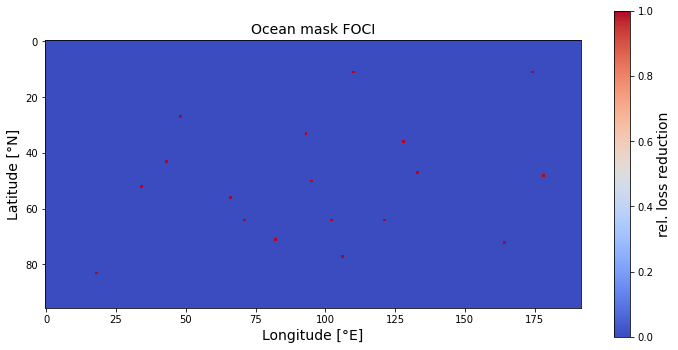

In [232]:
# Plot resulting ocean mask as heatmap:        
fig, ax = plt.subplots(figsize=(12, 6))
im = plt.imshow(np.flip(FOCI_mask,axis=0), cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Ocean mask FOCI', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
# plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
# plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

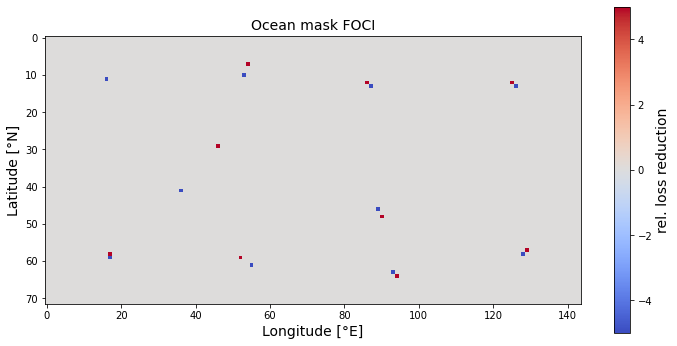

In [217]:
# Plot resulting ocean mask as heatmap:        
fig, ax = plt.subplots(figsize=(12, 6))
im = plt.imshow(np.flip(both_masks,axis=0), cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Ocean mask FOCI', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
# plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
# plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [118]:
path_to_CESM_mask = Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_CESM_variable_range_25_999_factor_3_final/relevance_1')
print(path_to_CESM_mask)

GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_CESM_variable_range_25_999_factor_3_final/relevance_1


In [133]:
CESM_mask = np.load(path_to_CESM_mask / "optimal_sampling_mask_999_realworld.npy")

In [96]:
CESM_mask.shape

(80, 176)

In [120]:
path_to_FOCI_mask = Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_FOCI_variable_range_25_999_factor_3_final/relevance_1')
print(path_to_FOCI_mask)



GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_FOCI_variable_range_25_999_factor_3_final/relevance_1


In [121]:
# np.save(path_to_FOCI_mask / "optimal_sampling_mask_999_realworld_flipped.npy",FOCI_mask)

In [134]:
FOCI_mask = np.load(path_to_FOCI_mask / "optimal_sampling_mask_999_realworld.npy")

In [137]:
FOCI_mask.shape

(88, 176)

In [135]:
both_masks=np.copy(CESM_mask.astype(float))

In [139]:
# both_masks[np.flip(np.isnan(sst_anomaly_fields[0]),axis=0)]=float('nan')

both_masks[CESM_mask]=5
both_masks[FOCI_mask]=-5

both_masks[np.flip(np.isnan(sst_dataset.sst[0,:-1,:-4]),axis=0)]=float('nan')
#both_masks[np.flip(np.isnan(sst_dataset.sst[0,5:-4,:-4]),axis=0)]=float('nan')

In [140]:
print(np.sum(np.isnan(both_masks[FOCI_mask])))
print(np.sum(np.isnan(both_masks[CESM_mask])))

0
0


In [68]:
path_to_missing_mask = Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_5conv_sst_realworld_fixed_discrete_factor_1_seed_1/missing_999')
print(path_to_missing_mask)


GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_5conv_sst_realworld_fixed_discrete_factor_1_seed_1/missing_999


In [69]:
temp_mask = np.load(path_to_missing_mask / 'missing_mask.npy')

In [72]:
np.sum(temp_mask,axis=(1,2))

array([6, 6, 6, ..., 6, 6, 6])

In [78]:
(np.size(np.isnan(sst_dataset.sst[0,5:-4,:-4].values))-np.sum(np.isnan(sst_dataset.sst[0,5:-4,:-4].values)))*0.05

495.65000000000003

In [77]:
80*176

14080

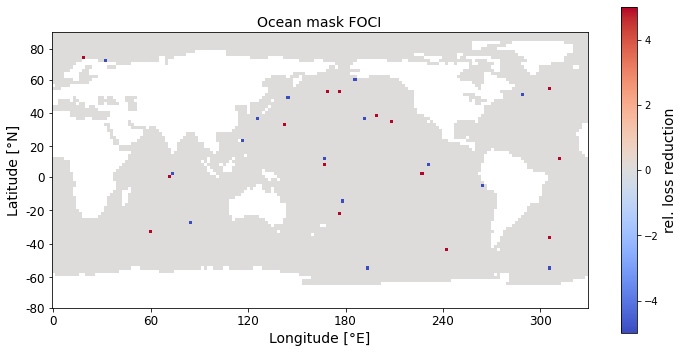

In [141]:
# Plot resulting ocean mask as heatmap:        
fig, ax = plt.subplots(figsize=(12, 6))
im = plt.imshow(np.flip(both_masks,axis=0), cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Ocean mask FOCI', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

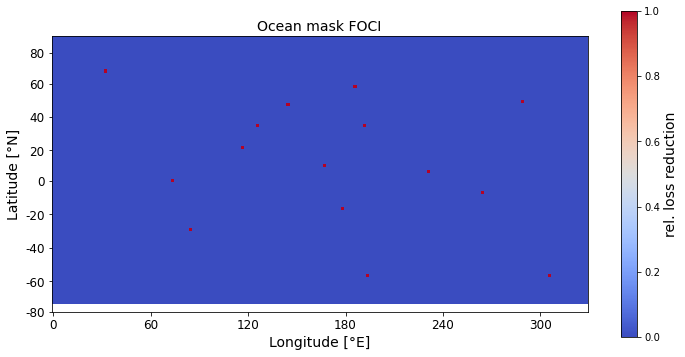

In [75]:
# Plot resulting ocean mask as heatmap:        
fig, ax = plt.subplots(figsize=(12, 6))
im = plt.imshow(FOCI_mask, cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Ocean mask FOCI', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [80]:
(FOCI_mask[FOCI_mask==True])

(15,)

In [19]:
# Data loading and preprocessing:
feature = "sea-surface-temperature"  # Choose either 'sea-level-pressure' or 'sea-surface-temperature' as feature.
feature_short = "sst"  # Free to set short name, to store results, e.g. 'slp' and 'sst'.
source = "realworld"  # Choose Earth System Model, either 'FOCI' or 'CESM'.
seed = 1  # Seed for random number generator, for reproducibility of missing value mask.
mask_type = "fixed"  # Can have random missing values, individually for each data sample ('variable'),
# or randomly create only a single mask, that is then applied to all samples identically ('fixed').
missing_type = "discrete"  # Either specify discrete amounts of missing values ('discrete') or give a range ('range').
augmentation_factor = (
    1  # Number of times, each sample is to be cloned, keeping the original order.
)
train_val_split = 0.8  # Set rel. amount of samples used for training.
missing=0.5

In [20]:
# Extend data, if desired:
data = clone_data(data=sst_anomaly_fields, augmentation_factor=augmentation_factor)

# Create mask for missing values:
missing_mask = create_missing_mask(
    data=data,
    mask_type=mask_type,
    missing_type=missing_type,
    missing_min=missing,
    missing_max=missing,
    seed=seed,
)

In [22]:
# Use sparse data as inputs and complete data as targets. Split sparse and complete data into training and validation sets.
# Scale or normlalize data according to statistics obtained from only training data.
(
    train_input,
    val_input,
    train_target,
    val_target,
    train_min,
    train_max,
    train_mean,
    train_std,
) = split_and_scale_data(data, missing_mask, train_val_split, scale_to='zero_one')


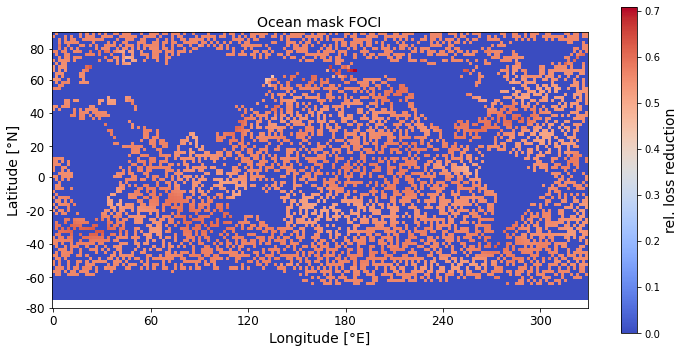

In [23]:
# Plot resulting ocean mask as heatmap:        
fig, ax = plt.subplots(figsize=(12, 6))
im = plt.imshow(val_input[0], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Ocean mask FOCI', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [11]:
# Look for FOCI test data:
find_data_files(data_path='GitHub/MarcoLandtHayen/reconstruct_missing_data/data/test_data/', data_source_name='FOCI')

[PosixPath('GitHub/MarcoLandtHayen/reconstruct_missing_data/data/test_data/FOCI/FOCI1.3-SW038_1m_23500101_23591231_grid_T_atmos_grid.nc'),
 PosixPath('GitHub/MarcoLandtHayen/reconstruct_missing_data/data/test_data/FOCI/FOCI1.3-SW038_echam6_ATM_mm_2350-2359_geopoth_pl_monthly_50000.nc'),
 PosixPath('GitHub/MarcoLandtHayen/reconstruct_missing_data/data/test_data/FOCI/FOCI1.3-SW038_echam6_BOT_mm_2350-2359_precip_monthly_1.nc'),
 PosixPath('GitHub/MarcoLandtHayen/reconstruct_missing_data/data/test_data/FOCI/FOCI1.3-SW038_echam6_BOT_mm_2350-2359_slp_monthly_1.nc'),
 PosixPath('GitHub/MarcoLandtHayen/reconstruct_missing_data/data/test_data/FOCI/FOCI1.3-SW038_echam6_BOT_mm_2350-2359_temp2_monthly_1.nc'),
 PosixPath('GitHub/MarcoLandtHayen/reconstruct_missing_data/data/test_data/FOCI/FOCI1.3-SW038_echam6_BOT_mm_2350-2359_tsw_monthly_1.nc')]

In [4]:
# Look for FOCI full data:
find_data_files(data_path='../../../../climate_index_collection/data/raw/2022-08-22/', data_source_name='FOCI')

[PosixPath('../../../../climate_index_collection/data/raw/2022-08-22/FOCI/FOCI1.3-SW038_1m_23500101_33491231_grid_T_atmos_grid.nc'),
 PosixPath('../../../../climate_index_collection/data/raw/2022-08-22/FOCI/FOCI1.3-SW038_echam6_ATM_mm_2350-3349_geopoth_pl_monthly_50000_midmonth.nc'),
 PosixPath('../../../../climate_index_collection/data/raw/2022-08-22/FOCI/FOCI1.3-SW038_echam6_BOT_mm_2350-3349_precip_monthly_1_midmonth.nc'),
 PosixPath('../../../../climate_index_collection/data/raw/2022-08-22/FOCI/FOCI1.3-SW038_echam6_BOT_mm_2350-3349_slp_monthly_1_midmonth.nc'),
 PosixPath('../../../../climate_index_collection/data/raw/2022-08-22/FOCI/FOCI1.3-SW038_echam6_BOT_mm_2350-3349_temp2_monthly_1.nc'),
 PosixPath('../../../../climate_index_collection/data/raw/2022-08-22/FOCI/FOCI1.3-SW038_echam6_BOT_mm_2350-3349_tsw_monthly_1_midmonth.nc')]

In [9]:
# Load CESM and FOCI data, including ALL fields and mask for Ocean values:

# data_CESM = load_data_set(data_path='../data/test_data/', data_source_name='CESM')
# data_FOCI = load_data_set(data_path='../data/test_data/', data_source_name='FOCI')

data_CESM = load_data_set(data_path='GitHub/MarcoLandtHayen/reconstruct_missing_data/data/test_data/', data_source_name='CESM')
data_FOCI = load_data_set(data_path='GitHub/MarcoLandtHayen/reconstruct_missing_data/data/test_data/', data_source_name='FOCI')

/opt/miniconda3/lib/python3.9/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/miniconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


In [10]:
data_CESM

<xarray.Dataset>
Dimensions:                  (time: 120, lat: 96, lon: 144)
Coordinates:
  * lat                      (lat) float64 -90.0 -88.11 -86.21 ... 88.11 90.0
  * lon                      (lon) float64 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * time                     (time) object 2350-01-16 12:00:00 ... 2359-12-16...
    plev                     float32 500.0
Data variables:
    precipitation            (time, lat, lon) float32 ...
    sea-level-pressure       (time, lat, lon) float32 ...
    sea-surface-temperature  (time, lat, lon) float32 nan nan nan ... nan 271.4
    surface-air-temperature  (time, lat, lon) float32 ...
    geopotential-height      (time, lat, lon) float32 ...
    sea-surface-salinity     (time, lat, lon) float64 nan nan nan ... nan 33.31
    is_over_ocean            (lat, lon) bool False False False ... False True
Attributes: (12/19)
    CDI:              Climate Data Interface version 1.9.9 (https://mpimet.mp...
    Conventions:      CF-1.0
    source:           CAM
    topography_file:  /work/bb0519/cesm1_0_6/inputdata/atm/cam/topo/USGS-gtop...
    initial_file:     b40.1850.track1.2deg.wcm.007.cam2.i.0156-01-01-00000.nc
    revision_Id:      $Id$
    ...               ...
    system:           Linux m11523 2.6.32-642.3.1.el6.x86_64 #1 SMP Sun Jun 2...
    conventions:      None
    title:            UNSET
    history:          Fri Sep  2 19:13:27 2022: ncks -O -d time,0,119,1 /gxfs...
    CDO:              Climate Data Operators version 1.9.9 (https://mpimet.mp...
    NCO:              netCDF Operators version 4.9.3 (Homepage = http://nco.s...

In [38]:
data_FOCI

<xarray.Dataset>
Dimensions:                  (lat: 96, lon: 192, time: 120)
Coordinates:
  * lat                      (lat) float64 88.57 86.72 84.86 ... -86.72 -88.57
  * lon                      (lon) float64 0.0 1.875 3.75 ... 354.4 356.2 358.1
  * time                     (time) object 2350-01-16 12:00:00 ... 2359-12-16...
    plev                     float64 5e+04
Data variables:
    sea-surface-salinity     (time, lat, lon) float64 32.0 32.02 ... nan nan
    geopotential-height      (time, lat, lon) float32 ...
    precipitation            (time, lat, lon) float32 ...
    sea-level-pressure       (time, lat, lon) float32 ...
    surface-air-temperature  (time, lat, lon) float32 ...
    sea-surface-temperature  (time, lat, lon) float32 271.4 271.4 ... nan nan
    is_over_ocean            (lat, lon) bool True True True ... False False
Attributes:
    history:  Fri Sep  2 19:13:28 2022: ncks -O -d time,0,119,1 -v sosaline /...
    NCO:      netCDF Operators version 4.9.3 (Homepage = http://nco.sf.net, C...

In [34]:
# Get anomalies:
slp_CESM_anomaly = get_anomalies(feature='sea-level-pressure', data_set=data_CESM) 
slp_FOCI_anomaly = get_anomalies(feature='sea-level-pressure', data_set=data_FOCI) 
sst_FOCI_anomaly = get_anomalies(feature='sea-surface-temperature', data_set=data_FOCI) 

In [13]:
slp_CESM_anomaly.shape

(120, 96, 144)

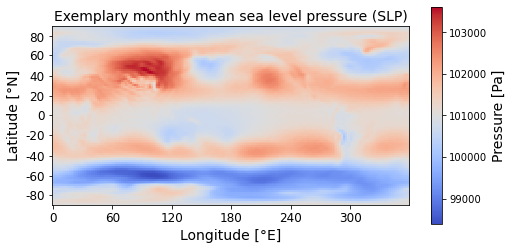

In [33]:
# Plot resulting ocean mask as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(data_FOCI['sea-level-pressure'].values[0], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('Pressure [Pa]', fontsize=14)
plt.title('Exemplary monthly mean sea level pressure (SLP)', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

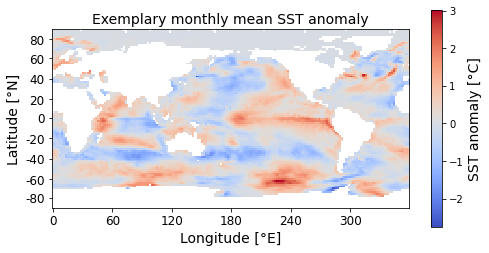

In [44]:
# Plot resulting ocean mask as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(sst_FOCI_anomaly[60], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('SST anomaly [°C]', fontsize=14)
plt.title('Exemplary monthly mean SST anomaly', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [4]:
# Extract single field, here: Sea level pressure
slp_CESM = data_CESM['sea-level-pressure'].values
slp_CESM.shape

(120, 96, 144)

In [21]:
# Flatten slp CESM anomaliy fields to have a time series for each grid point:
slp_CESM_anomaly_flat = slp_CESM_anomaly.reshape((slp_CESM_anomaly.shape[0],slp_CESM_anomaly.shape[1]*slp_CESM_anomaly.shape[2]))

In [28]:
slp_CESM_anomaly_flat_df = pd.DataFrame(slp_CESM_anomaly_flat, columns = (np.arange(0,slp_CESM_anomaly_flat.shape[1])).astype(str))

In [38]:
slp_extract = slp_CESM_anomaly_flat_df.iloc[:,2000:2500]

<AxesSubplot:title={'center':'Pairwise correlation of grid points in slp CESM anomalies'}>

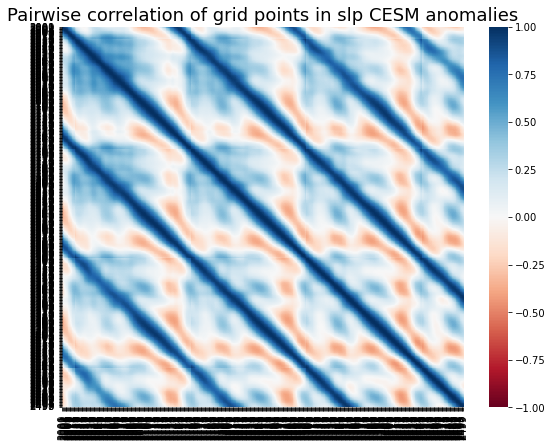

In [39]:
# Plot pairwise correlation coefficients of grid points in slp CESM anomalies:
fig, ax = plt.subplots(figsize=(9,7))
plt.title('Pairwise correlation of grid points in slp CESM anomalies', fontsize=18)
sns.heatmap(
    slp_extract.corr(), 
    cmap="RdBu", 
    xticklabels=True, 
    yticklabels=True,
    center=0,
    vmin=-1,
    vmax=1,
)

In [21]:
# Extract single field, here: Sea level pressure
slp_FOCI = data_FOCI['sea-level-pressure'].values
slp_FOCI.shape

(120, 96, 192)

In [17]:
# Extract single field, here: Sea surface temperature
sst_CESM = data_CESM['sea-surface-temperature'].values
sst_CESM.shape

(120, 96, 144)

In [22]:
# Extract single field, here: Sea surface temperature
sst_FOCI = data_FOCI['sea-surface-temperature'].values
sst_FOCI.shape

(120, 96, 192)

In [7]:
np.sum(np.isnan(sst_CESM))

665760

In [23]:
# Extract ocean mask:
is_over_ocean_CESM = data_CESM['is_over_ocean'].values
is_over_ocean_CESM.shape

(96, 144)

In [25]:
# Extract ocean mask:
is_over_ocean_FOCI = data_FOCI['is_over_ocean'].values
is_over_ocean_FOCI.shape

(96, 192)

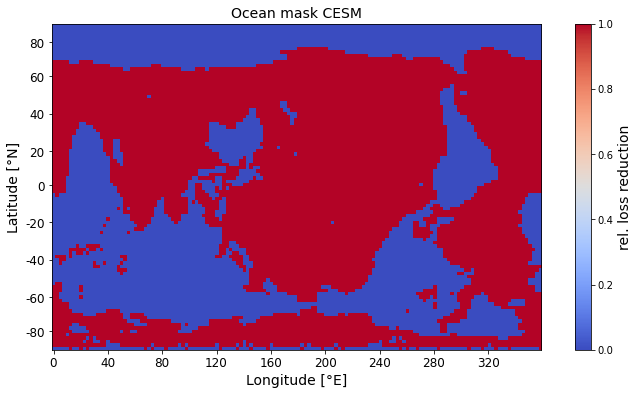

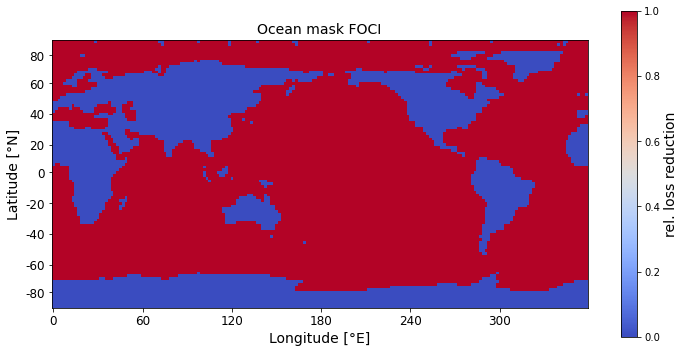

In [27]:
# Plot resulting ocean mask as heatmap:        
fig, ax = plt.subplots(figsize=(12, 6))
im = plt.imshow(is_over_ocean_CESM, cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Ocean mask CESM', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Plot resulting ocean mask as heatmap:        
fig, ax = plt.subplots(figsize=(12, 6))
im = plt.imshow(is_over_ocean_FOCI, cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Ocean mask FOCI', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

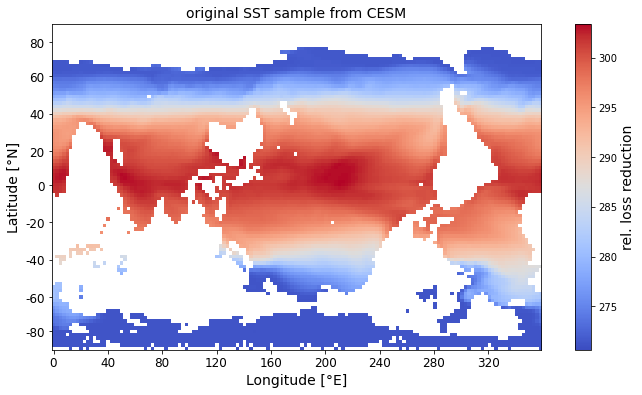

In [33]:
# Plot first SST sample from CESM test data:        
fig, ax = plt.subplots(figsize=(12, 6))
im = plt.imshow(sst_CESM[0], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('original SST sample from CESM', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

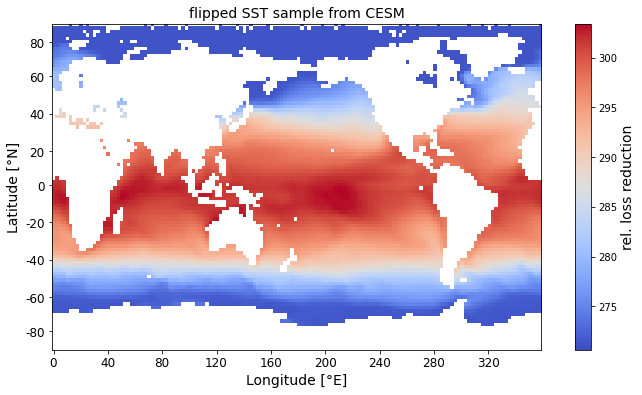

In [32]:
# Plot first SST sample from CESM test data:        
fig, ax = plt.subplots(figsize=(12, 6))
im = plt.imshow(np.flip(sst_CESM[0], axis=0), cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('flipped SST sample from CESM', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [62]:
## Derive mask for showing only the continents' silhouette as NaN values, for better orientation in slp fields.

# Initialize storage for silhouette as boolean mask:
land_silhouette_CESM = (np.zeros(is_over_ocean_CESM.shape)!=0)

# Loop over latitude in ocean mask, to scan mask line-by-line:
for i in range(is_over_ocean_CESM.shape[0]):
    
    # Loop over longitude, to scan current line:
    for j in range(is_over_ocean_CESM.shape[1]):
        
        # Check, if current grid point is over land, while previous grid point was over ocean.
        # Take care of initial border:
        if j>0:
            if (is_over_ocean_CESM[i,j]==False) & (is_over_ocean_CESM[i,j-1]==True):
                
                # Set land silhouette:
                land_silhouette_CESM[i,j] = True
                
        # Check, if current grid point is over ocean, while previous grid point was over land.
        # Take care of initial border:
        if j>0:
            if (is_over_ocean_CESM[i,j]==True) & (is_over_ocean_CESM[i,j-1]==False):
                
                # Set land silhouette:
                land_silhouette_CESM[i,j] = True
                
# Loop over longitude in ocean mask, to scan mask row-by-row:
for j in range(is_over_ocean_CESM.shape[1]):
    
    # Loop over latitude, to scan current row:
    for i in range(is_over_ocean_CESM.shape[0]):
        
        # Check, if current grid point is over land, while previous grid point was over ocean.
        # Take care of initial border:
        if i>0:
            if (is_over_ocean_CESM[i,j]==False) & (is_over_ocean_CESM[i-1,j]==True):
                
                # Set land silhouette:
                land_silhouette_CESM[i,j] = True
                
        # Check, if current grid point is over ocean, while previous grid point was over land.
        # Take care of initial border:
        if i>0:
            if (is_over_ocean_CESM[i,j]==True) & (is_over_ocean_CESM[i-1,j]==False):
                
                # Set land silhouette:
                land_silhouette_CESM[i,j] = True
            

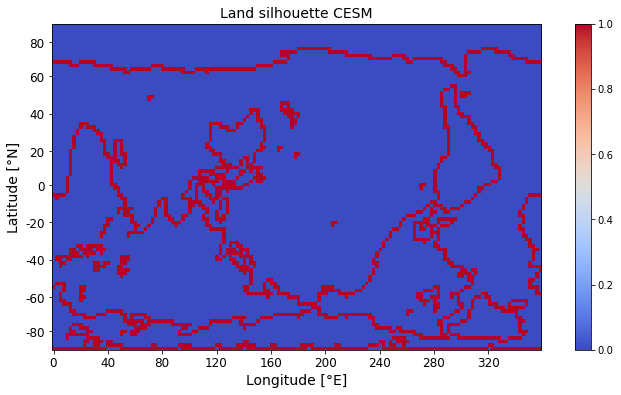

In [69]:
# Plot resulting land silhouette as heatmap:        
fig, ax = plt.subplots(figsize=(12, 6))
im = plt.imshow(land_silhouette_CESM, cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('', fontsize=14)
plt.title('Land silhouette CESM', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [70]:
# Select single feature and compute anomalies, using whole time span as climatology:
data = get_anomalies(feature='sea-level-pressure', data_set=data_CESM) 

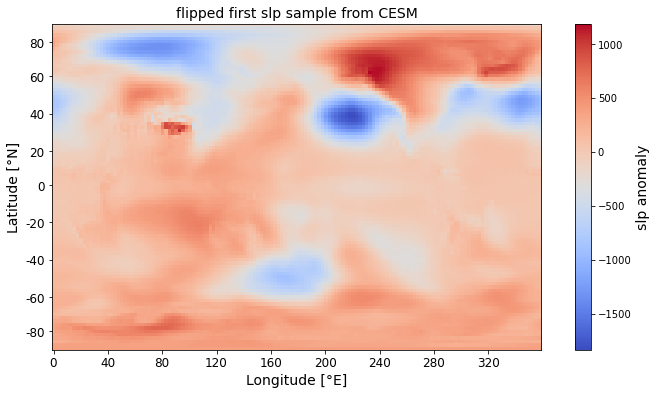

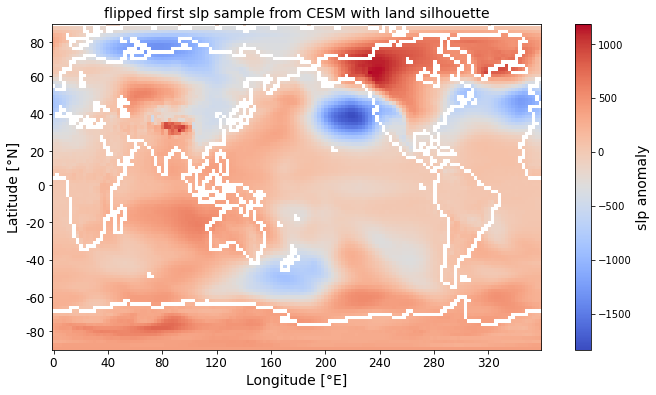

In [71]:
# Extract first sample:
temp_sample = data[0]

# Plot flipped original sample:        
fig, ax = plt.subplots(figsize=(12, 6))
im = plt.imshow(np.flip(temp_sample,axis=0), cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('slp anomaly', fontsize=14)
plt.title('flipped first slp sample from CESM', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Add land silhouette as NaN values:
temp_sample[land_silhouette_CESM]=float('nan')

# Plot flipped sample with land silhouette:        
fig, ax = plt.subplots(figsize=(12, 6))
im = plt.imshow(np.flip(temp_sample,axis=0), cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('slp anomaly', fontsize=14)
plt.title('flipped first slp sample from CESM with land silhouette', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [11]:
missing_mask = create_missing_mask(data=data, mask_type='fixed', missing_type='discrete', missing_min=0.9, missing_max=0.9, seed=0)

In [23]:
np.sum(np.isnan(data))

0

In [13]:
np.sum(missing_mask,axis=(1,2))

array([1835, 1835, 1835, ..., 1835, 1835, 1835])

In [14]:
# Use sparse data as inputs and complete data as targets. Split sparse and complete data into training and validation sets. 
# Scale or normlalize data according to statistics obtained from only training data.
train_input, val_input, train_target, val_target, train_min, train_max, train_mean, train_std = split_and_scale_data(
    data, 
    missing_mask, 
    train_val_split=0.8, 
    scale_to='zero_one'
)

In [24]:
temp_number = np.sum(train_target==0) + np.sum(val_target==0)

In [19]:
np.size(data)*0.9

199065600.0

In [20]:
(np.sum(train_input==0) + np.sum(val_input==0)) - (np.size(data)*0.9)

6734400.0

In [26]:
(np.sum(train_input!=0) + np.sum(val_input!=0)) 

15384000

In [27]:
(np.size(data) - temp_number)*0.1

15538799.9

In [76]:
np.sum(np.isnan(data))

65796000

In [69]:
data[np.isnan(data)]=0

In [71]:
np.max(data)

13.437347

In [ ]:
   

# Extend data, if desired:
data = clone_data(data=data, augmentation_factor=augmentation_factor)

In [ ]:
sst_FOCI[!] = 0

In [36]:
ocean = np.repeat(np.expand_dims(is_over_ocean,axis=0),sst_FOCI.shape[0],axis=0)

In [37]:
sst_FOCI[(ocean==False)]=0

In [38]:
np.sum(np.isnan(sst_FOCI))

0

In [35]:
ocean

(12000, 96, 192)

In [55]:
np.sum(np.isnan(data_FOCI['sea-surface-temperature'].where(data_FOCI["is_over_ocean"]).values))

65796000

In [51]:
np.random.seed(0)
np.random.uniform(low=0, high=1, size=(2,3))

array([[0.5488135 , 0.71518937, 0.60276338],
       [0.54488318, 0.4236548 , 0.64589411]])

In [1]:
# Description:
#
# Following [Xiantao et al., 2020] approach: Test U-Net to reconstruct complete data from sparse inputs.
# Opposed to their net, only have 4 instead of 5 convolutional layers.
# Work with sea level pressure (slp) fields from Earth System Models, either FOCI or CESM.

import os
import sys
# sys.path.append(
#     "GitHub/MarcoLandtHayen/reconstruct_missing_data/reconstruct_missing_data"
# )

sys.path.append('../reconstruct_missing_data')

from pathlib import Path
from json import dump, load

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

from data_loading import (
    find_data_files, 
    load_data_set, 
    get_anomalies, 
    clone_data, 
    create_missing_mask, 
    split_and_scale_data,
    area_mean_weighted,
    spatial_mask,
)
from models import build_unet_4conv
from indices import (
    southern_annular_mode_zonal_mean,
    north_atlantic_oscillation_station,
    north_pacific,
    el_nino_southern_oscillation_34,
    atlantic_multidecadal_oscillation,
)

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, concatenate, Conv1D, Conv2D, MaxPool2D, UpSampling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.utils import plot_model

# Suppress Tensorflow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Set path to final model:

# sst CESM:
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_CESM_fixed_discrete_factor_1_final'
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_CESM_variable_discrete_factor_1_final'
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_CESM_variable_discrete_factor_2_final'
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_CESM_variable_discrete_factor_3_final'
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_CESM_optimal_discrete_factor_1_final'

# sst FOCI:
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_FOCI_fixed_discrete_factor_1_final'
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_FOCI_variable_discrete_factor_1_final'
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_FOCI_variable_discrete_factor_2_final'
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_FOCI_variable_discrete_factor_3_final'
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_FOCI_optimal_discrete_factor_1_final'

# sst realworld:
path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_realworld_fixed_discrete_factor_1_final'
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_realworld_variable_discrete_factor_1_final'
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_realworld_variable_discrete_factor_2_final'
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_realworld_variable_discrete_factor_3_final'
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_realworld_optimal_from_CESM_discrete_factor_1_final'
#path_to_final_model='GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_realworld_optimal_from_FOCI_discrete_factor_1_final'



In [2]:
# Set working directory, according to working directory in scripts:
os.chdir('/gxfs_work1/geomar/smomw511')

In [3]:
# Reload parameters for this experiment:
with open(Path(path_to_final_model) / 'parameters.json', 'r') as f:
    parameters=load(f)

feature = parameters['feature']
feature_short = parameters['feature_short']
source = parameters['source']
mask_type = parameters['mask_type']
missing_type = parameters['missing_type']
augmentation_factor = parameters['augmentation_factor']
train_val_split = parameters['train_val_split']
missing_values = parameters['missing_values'] #or set manually: [0.999, 0.99, 0.95, 0.9, 0.75, 0.5] 
scale_to = parameters['scale_to']

# Real world data needs separate pre-processing:
if source == 'realworld':
    
    # Path to full data:
    path_to_data = "GitHub/MarcoLandtHayen/reconstruct_missing_data/data/raw/sst.mnmean.nc"  

    ## Load data:

    # Open data set:
    sst_dataset=xr.open_dataset(path_to_data)
  
    # Start with raw slp fields as lat/lon grids in time, from 1948 to 2022:
    sst_fields = (
        sst_dataset.sst
        .sel(time=slice('1880-01-01', '2022-12-01'))
    )

    # Extract time, latitude and longitude dimensions.
    # Already consider, that latitude and longitude are truncated below:
    time = sst_fields['time']
    latitude = sst_fields['lat'][:-1]
    longitude = sst_fields['lon'][:-4]
    
    # Get number of train and validation samples: Consider augmentation factor!
    n_train = int(len(sst_fields) * augmentation_factor * train_val_split)
    n_val = ((len(sst_fields) * augmentation_factor) - n_train)
    
    # Compute monthly climatology (here 1980 - 2009) for whole world:
    sst_climatology_fields = (
        sst_dataset.sst
        .sel(time=slice('1980-01-01','2009-12-01'))
        .groupby("time.month")
        .mean("time")
    )

    # Get slp anomaly fields by subtracting monthly climatology from raw slp fields:
    sst_anomaly_fields = sst_fields.groupby("time.month") - sst_climatology_fields

    # Remove last row (latidute) and last 4 columns (longitude), to have even number of steps in latitude (=88)
    # and longitude (=176), that can be evenly divided 4 times by two. This serves as 'quick-and-dirty'
    # solution to avoid problems with UPSAMPLING in U-Net. There must be a more elegant way, take care of it later!
    sst_anomaly_fields = sst_anomaly_fields.values[:,:-1,:-4]
   
    # Extend data, if desired:
    data = clone_data(data=sst_anomaly_fields, augmentation_factor=augmentation_factor)

else:

    # Path to full data:
    path_to_data = 'climate_index_collection/data/raw/2022-08-22/'

    # Load data:
    data = load_data_set(data_path=path_to_data, data_source_name=source)

    # Extract time, latitude and longitude dimensions:
    time = data['time']
    latitude = data['lat']
    longitude = data['lon']

    # Get number of train and validation samples: Consider augmentation factor!
    n_train = int(len(data[feature]) * augmentation_factor * train_val_split)
    n_val = ((len(data[feature]) * augmentation_factor) - n_train)

    # Select single feature and compute anomalies, using whole time span as climatology:
    data = get_anomalies(feature=feature, data_set=data)

    # Extend data, if desired:
    data = clone_data(data=data, augmentation_factor=augmentation_factor)

In [4]:
# Extend time dimension, according to augmentation factor:
for t in range(len(time)):

    # Loop over augmentation_facor:
    for j in range(augmentation_factor):

        # Initialize storage for extended time line:
        if (t==0) & (j==0):
            extended_time=time[t].values
        else:
            extended_time = np.hstack([extended_time,time[t].values])

# Convert extended time line to xarray DataArray:
extended_time_xr = xr.DataArray(
    extended_time,
    name='time',
    dims=('time'),
    coords={'time': extended_time}
)

# Initialize storage for loss per sample, dimension: (#missing values, #samples)
train_loss_per_sample_all = np.zeros((len(missing_values),n_train))
val_loss_per_sample_all = np.zeros((len(missing_values),n_val))

# Initialize storage for mean loss maps, dimension: (#missing values, latitude, longitude)
train_loss_map_all = np.zeros((len(missing_values),data.shape[1],data.shape[2]))
val_loss_map_all = np.zeros((len(missing_values),data.shape[1],data.shape[2]))

# Initialize storage for indices, dimension: (#missing values, #samples)
ENSO_train_pred_all = np.zeros((len(missing_values),n_train))
ENSO_val_pred_all = np.zeros((len(missing_values),n_val))
ENSO_train_target_all = np.zeros((len(missing_values),n_train))
ENSO_val_target_all = np.zeros((len(missing_values),n_val))

AMO_train_pred_all = np.zeros((len(missing_values),n_train))
AMO_val_pred_all = np.zeros((len(missing_values),n_val))
AMO_train_target_all = np.zeros((len(missing_values),n_train))
AMO_val_target_all = np.zeros((len(missing_values),n_val))

In [5]:
i = 1

# Get current rel. amount of missing values:
missing = missing_values[i]

## Reconstruct sparse data (as inputs) and complete data (as targets).

# Reload mask for missing values.
# Rel. amount of missing values = 0.999 requires special treatment:
if missing==0.999:
    missing_mask = np.load(Path(path_to_final_model) / 'missing_' f'{int(missing*1000)}' / 'missing_mask.npy')
else:
    missing_mask = np.load(Path(path_to_final_model) / 'missing_' f'{int(missing*100)}' / 'missing_mask.npy')

# Use sparse data as inputs and complete data as targets. Split sparse and complete data into training and validation sets. 
# Scale or normlalize data according to statistics obtained from only training data.
train_input, val_input, train_target, val_target, train_min, train_max, train_mean, train_std = split_and_scale_data(
    data, 
    missing_mask, 
    train_val_split, 
    scale_to
)

In [6]:
# Reload model: Rel. amount of missing values = 0.999 requires special treatment.
if missing==0.999:
    model = tf.keras.models.load_model(Path(path_to_final_model) / 'missing_' f'{int(missing*1000)}' / 'model')
else:
    model = tf.keras.models.load_model(Path(path_to_final_model) / 'missing_' f'{int(missing*100)}' / 'model')

# Get predictions:
#train_pred = model.predict(train_input)
val_pred = model.predict(val_input)

# Compute loss per sample:
#train_loss_per_sample = np.mean((train_pred[:,:,:,0]-train_target)**2,axis=(1,2))
val_loss_per_sample = np.mean((val_pred[:,:,:,0]-val_target)**2,axis=(1,2))

# Store loss per sample:
#train_loss_per_sample_all[i] = train_loss_per_sample
val_loss_per_sample_all[i] = val_loss_per_sample

# Compute mean loss maps:
#train_loss_map = np.mean((train_pred[:,:,:,0]-train_target)**2,axis=0)
val_loss_map = np.mean((val_pred[:,:,:,0]-val_target)**2,axis=0)

# Store mean loss maps:
#train_loss_map_all[i] = train_loss_map
val_loss_map_all[i] = val_loss_map



2023-02-20 14:59:48.918026: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /.singularity.d/libs
2023-02-20 14:59:48.918057: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-20 14:59:48.918085: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (neshcl104): /proc/driver/nvidia/version does not exist
2023-02-20 14:59:48.918321: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-20 14:59:49.739182: I tensorflow/compile

In [7]:
## Compute and store indices: ENSO and AMO
# Convert predictions and targets to xarray.DataArray:
# train_pred_xr = xr.DataArray(
#     train_pred[:,:,:,0],
#     dims=('time', 'lat', 'lon'),
#     coords={'time': extended_time[:n_train], 'lat': latitude, 'lon': longitude}
# )
val_pred_xr = xr.DataArray(
    val_pred[:,:,:,0],
    dims=('time', 'lat', 'lon'),
    coords={'time': extended_time[n_train:], 'lat': latitude, 'lon': longitude}
)
# train_target_xr = xr.DataArray(
#     train_target[:,:,:],
#     dims=('time', 'lat', 'lon'),
#     coords={'time': extended_time[:n_train], 'lat': latitude, 'lon': longitude}
# )
val_target_xr = xr.DataArray(
    val_target[:,:,:],
    dims=('time', 'lat', 'lon'),
    coords={'time': extended_time[n_train:], 'lat': latitude, 'lon': longitude}
)   

In [8]:
# Compute indices:
#ENSO_train_pred = el_nino_southern_oscillation_34(train_pred_xr).values
ENSO_val_pred = el_nino_southern_oscillation_34(val_pred_xr).values
#ENSO_train_target = el_nino_southern_oscillation_34(train_target_xr).values
ENSO_val_target = el_nino_southern_oscillation_34(val_target_xr).values

#AMO_train_pred = atlantic_multidecadal_oscillation(train_pred_xr).values
AMO_val_pred = atlantic_multidecadal_oscillation(val_pred_xr).values
#AMO_train_target = atlantic_multidecadal_oscillation(train_target_xr).values
AMO_val_target = atlantic_multidecadal_oscillation(val_target_xr).values



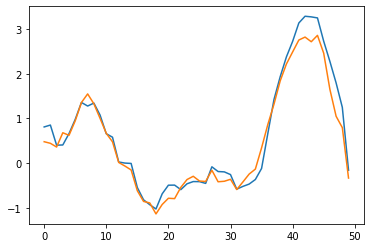

In [9]:
plt.plot(ENSO_val_pred[:50])
plt.plot(ENSO_val_target[:50])

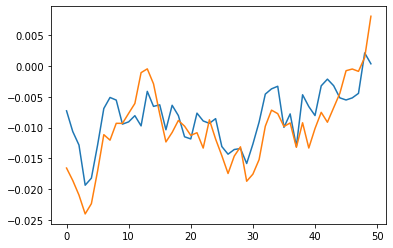

In [10]:
plt.plot(AMO_val_pred[:50])
plt.plot(AMO_val_target[:50])

In [233]:



# Loop over rel. amounts of missing values:
for i in range(len(missing_values)):

    # Get status:
    print('missing: ',i+1,' of ',len(missing_values))
    
    # Get current rel. amount of missing values:
    missing = missing_values[i]

    ## Reconstruct sparse data (as inputs) and complete data (as targets).
    
    # Reload mask for missing values.
    # Rel. amount of missing values = 0.999 requires special treatment:
    if missing==0.999:
        missing_mask = np.load(Path(path_to_final_model) / 'missing_' f'{int(missing*1000)}' / 'missing_mask.npy')
    else:
        missing_mask = np.load(Path(path_to_final_model) / 'missing_' f'{int(missing*100)}' / 'missing_mask.npy')

    # Use sparse data as inputs and complete data as targets. Split sparse and complete data into training and validation sets. 
    # Scale or normlalize data according to statistics obtained from only training data.
    train_input, val_input, train_target, val_target, train_min, train_max, train_mean, train_std = split_and_scale_data(
        data, 
        missing_mask, 
        train_val_split, 
        scale_to
    )
    
    # Reload model: Rel. amount of missing values = 0.999 requires special treatment.
    if missing==0.999:
        model = tf.keras.models.load_model(Path(path_to_final_model) / 'missing_' f'{int(missing*1000)}' / 'model')
    else:
        model = tf.keras.models.load_model(Path(path_to_final_model) / 'missing_' f'{int(missing*100)}' / 'model')

    # Get predictions:
    train_pred = model.predict(train_input)
    val_pred = model.predict(val_input)
    
    # Compute loss per sample:
    train_loss_per_sample = np.mean((train_pred[:,:,:,0]-train_target)**2,axis=(1,2))
    val_loss_per_sample = np.mean((val_pred[:,:,:,0]-val_target)**2,axis=(1,2))
    
    # Store loss per sample:
    train_loss_per_sample_all[i] = train_loss_per_sample
    val_loss_per_sample_all[i] = val_loss_per_sample
        
    # Compute mean loss maps:
    train_loss_map = np.mean((train_pred[:,:,:,0]-train_target)**2,axis=0)
    val_loss_map = np.mean((val_pred[:,:,:,0]-val_target)**2,axis=0)
    
    # Store mean loss maps:
    train_loss_map_all[i] = train_loss_map
    val_loss_map_all[i] = val_loss_map
    
    ## Compute and store indices: SAM, NAO, NP
    
    # Convert predictions and targets to xarray.DataArray:
    train_pred_xr = xr.DataArray(
        train_pred[:,:,:,0],
        dims=('time', 'lat', 'lon'),
        coords={'time': extended_time[:n_train], 'lat': latitude, 'lon': longitude}
    )
    val_pred_xr = xr.DataArray(
        val_pred[:,:,:,0],
        dims=('time', 'lat', 'lon'),
        coords={'time': extended_time[n_train:], 'lat': latitude, 'lon': longitude}
    )
    train_target_xr = xr.DataArray(
        train_target[:,:,:],
        dims=('time', 'lat', 'lon'),
        coords={'time': extended_time[:n_train], 'lat': latitude, 'lon': longitude}
    )
    val_target_xr = xr.DataArray(
        val_target[:,:,:],
        dims=('time', 'lat', 'lon'),
        coords={'time': extended_time[n_train:], 'lat': latitude, 'lon': longitude}
    )   

missing:  1  of  3


2023-02-20 14:07:51.660367: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /.singularity.d/libs
2023-02-20 14:07:51.660399: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-20 14:07:51.660410: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (neshcl104): /proc/driver/nvidia/version does not exist
2023-02-20 14:07:51.660571: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-20 14:07:53.116609: I tensorflow/compile

missing:  2  of  3
missing:  3  of  3


KeyboardInterrupt: 